In [379]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(420)
N = 10000

In [380]:
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp 

class SIS:
    def __init__(self, phi, beta, varx, varz, x, L, f):
        self.phi = phi
        self.beta = beta
        self.varx = varx
        self.varz = varz
        self.x = x
        self.N = len(x)
        self.L = L
        self.f = f
        
        self.w  = np.zeros((2,L,len(x)))
        self.z  = np.zeros((2,L,len(x)))
    
    def run(self, resample=False):
        #copy for local work
        wc = self.w.copy()
        z = self.z.copy()

        theta = np.zeros((2,self.N))

        logw = np.zeros((2,self.L))
        theta[:, 0] = np.random.randn(2)

        for t in range(1, self.N):
            z[0,:,t] = self.phi * z[0,:,t-1] + np.sqrt(self.varz) * np.random.randn(self.L)     
            z[1,:,t] = self.phi * z[1,:,t-1] + np.sqrt(self.varz) * np.random.randn(self.L)     

            theta[0,t] = np.dot(wc[0,:,t-1],z[0,:,t]) #produce prediction
            theta[1,t] = np.dot(wc[1,:,t-1],z[1,:,t]) #produce prediction

            h = self.beta * self.f(theta[:,t-1], self.x[t, 0:2]) * (1 - self.f(theta[:,t-1], self.x[t, 0:2])) * self.x[t, 0:2]

            logw[0] += norm.logpdf(self.x[t, 2], loc=h[0], scale=np.sqrt(self.varx)) #generate weights
            logw[1] += norm.logpdf(self.x[t, 2], loc=h[1], scale=np.sqrt(self.varx)) #generate weights

            wt0 = np.exp(logw[0] - logsumexp(logw[0])) #normalise weights
            wt1 = np.exp(logw[1] - logsumexp(logw[1])) #normalise weights

            theta[0,t] = np.dot(wt0,z[0,:,t]) #produce prediction
            theta[1,t] = np.dot(wt1,z[1,:,t]) #produce prediction
                        
            wc[0,:,t] = wt0 #logging before resample weights
            wc[1,:,t] = wt1 #logging before resample weights

            if(resample):
                (wt0, z[0,:,t]) = self.resample(wt0, z[0,:,t])
                (wt1, z[1,:,t]) = self.resample(wt1, z[1,:,t])

                logw[0] = np.log(wt0) #reset log of weights with new resampled weights
                logw[1] = np.log(wt1) #reset log of weights with new resampled weights
        
        return (theta, wc, z)
    
    def resample(self, w, y):
        L = len(w)
        
        s = np.zeros(L)
        u = np.zeros(L)
        c = np.zeros(L)
        i = 1
        
        u[0] = np.random.uniform(0, (1/L))
        
        for l in range(1,L):
            c[l] = c[l-1] + w[l-1]
            u[l] = u[l-1] + (1/L)

        for l in range(L):
            while(i != L and u[l] > c[i]):
                i += 1
            s[l] = y[i-1]
        w = np.ones(L)/L    
        return (w,s)
    
    def resampling(self,w,z):
        N = w.shape[0]
        u = (np.arange(N) + np.random.rand(N))/N
        bins = np.cumsum(w)
        return (np.ones(N)/N, z[np.digitize(u, bins)])

In [381]:
def logisticReg(theta, x):
    return (1 + np.exp(-(theta.T @ x)))**-1

In [382]:
    def CrossEntropy(yHat, y):
        if y == 1:
            return -np.log(yHat)
        else:
            return -np.log(1 - yHat)

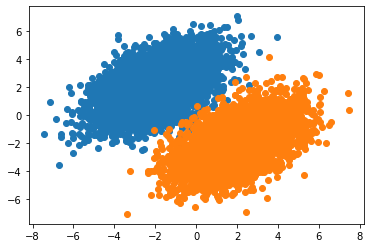

In [383]:
NumDataPerClass = int(N/2)
# Two-class problem, distinct means, equal covariance matrices
#
a = 2 
m1 = np.array([-a, a])
m2 = np.array([a, -a])
C = [[2, 1], [1, 2]]
# Set up the data by generating isotropic Guassians and
# rotating them accordingly
#
A = np.linalg.cholesky(C)

U1 = np.random.randn(NumDataPerClass,2)
X1 = U1 @ A.T + m1
Y1 = np.ones((NumDataPerClass, 1))

U2 = np.random.randn(NumDataPerClass,2)
X2 = U2 @ A.T + m2
Y2 = np.zeros((NumDataPerClass, 1))

X = np.vstack((X1, X2))
Y = np.vstack((Y1, Y2))
y = np.hstack((X, Y))
np.random.shuffle(y)

plt.scatter(X1[:, 0], X1[:,1])
plt.scatter(X2[:, 0], X2[:,1])

Text(0.5, 1.0, '$\\theta$[1]')

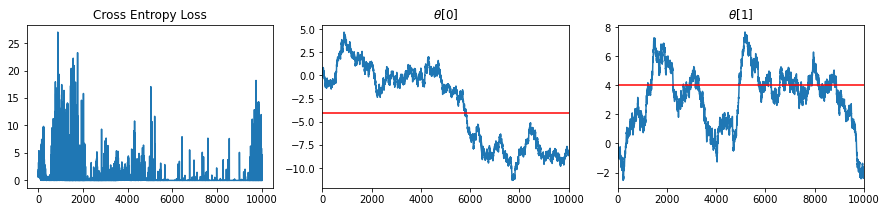

In [390]:
L = 100
sis = SIS(1,0.1,0.9,0.9,y,L,logisticReg)
(p, w, z) = sis.run(resample=True)

w = np.linalg.inv(C) @ (m1 - m2)
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,3))
ax[0].set_title("Cross Entropy Loss")
ax[0].plot([CrossEntropy(logisticReg(p.T[i], X[i]),Y[i]) for i in range(len(X))])

ax[1].plot(p[0])
ax[1].axhline(w[0],color='r')
ax[1].set_xlim(0,N)   
ax[1].set_title("$\\theta$[0]")

ax[2].plot(p[1])
ax[2].axhline(w[1],color='r')
ax[2].set_xlim(0,N)
ax[2].set_title("$\\theta$[1]")
#fig.savefig("SIRALL.png")

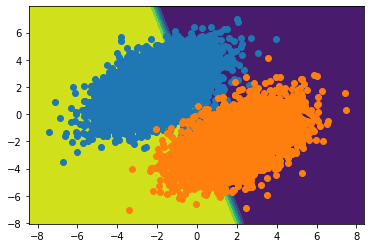

In [391]:
fig, ax = plt.subplots()
h = 0.1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = logisticReg(p.T[-1], [xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z)
ax.scatter(X1[:, 0], X1[:,1])
ax.scatter(X2[:, 0], X2[:,1])


#fig.savefig("DecisionBoundary.png")


In [367]:
def ESS(w):
    ESS = [np.sum(w[:,t]**2)**-1 for t in range(N)]
    return ESS

def ESSPlot(w, n="ESSPlot"):
    plt.plot(ESS(w), label="ESS")
    plt.axhline(len(w), c='orange',label="L")
    plt.legend()
    plt.ylabel("Particles")
    plt.xlabel("Time index")
    plt.savefig(n)
    plt.show()
    
def ESSComp(w1, w2, n="ESSComp"):
    plt.plot(ESS(w1), label="ESS SIS")
    plt.plot(ESS(w2), label="ESS SIR")
    plt.axhline(len(w), c='red',label="L")
    plt.legend()
    plt.ylabel("Particles")
    plt.xlabel("Time index")
    plt.savefig(n)
    plt.show()
    
def scatter(fig, ax, x, y, color, alpha_arr, **kwarg):
    r, g, b = to_rgb(color)
    # r, g, b, _ = to_rgba(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    plt.scatter(x, y, c=color, **kwarg)
    
def weightDegPlot(w, n="DegPlot"):
    i = 1 
    a = np.linspace(0, N, N)
    s = np.zeros((len(w),len(w[0])))
    
    for t in range(len(w[0])):
        s[:,t] = w[:,t]/sum(w[:,t])
    
    fig, ax = plt.subplots(figsize=(20,5))

    for l in w:
        scatter(fig, ax, a, [i]*len(a), 'blue', s[i-1])
        i += 1
        
    ax.set_ylabel("Particle index")
    ax.set_xlabel("Time index")
    #fig.savefig(n)
    fig.show()

In [364]:
import imageio
import os

filenames = []
n = 0
for i in p.T:
    # plot the line chart

    Z = logisticReg(i, [xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z)
    plt.scatter(X1[:, 0], X1[:,1])
    plt.scatter(X2[:, 0], X2[:,1])
    
    # create file name and append it to a list
    filename = f'imgs/frame_{n}.png'
    filenames.append(filename)
    n += 1
    # save frame
    plt.savefig(filename)
    plt.close()
    
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [368]:
weightDegPlot(w)

TypeError: object of type 'numpy.float64' has no len()